In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

ResNet18 모델을 이용해서 이미지 분류(classification) 실습 진행
- Pytorch Hub 공식 ResNet18 architecture를 이용해서 학습된 모델을 이용용

In [2]:
#GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

**ImageNet에 정의된 클래스 정보 가져오기**

In [3]:
from urllib.request import urlretrieve
import json

#이미지넷에 정의된 1000개의 레이블(클래스) 정보 가져오기
imagenet_json,_=urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
  imagenet_labels = json.load(f)

In [6]:
#20번째 index에 해당하는 것은 water ouzel,dipper
print(imagenet_labels[20])

water ouzel, dipper


이미지 처리 함수 정의 및 이미지 가져와서 출력
- ResNet은 일반적으로 이미지에 대해서 **Resize, CenterCrop, ToTensor()**와 **입력데이터 정규화**를 사용하는 모델

In [7]:
#입력데이터 전처리
preprocess = transforms.Compose([
                                 transforms.Resize(256), #이미지의 크기 변경
                                 transforms.CenterCrop(224), #이미지의 중앙부분을 잘라서 크기 조절
                                 transforms.ToTensor(), #torch.Tensor 형식으로 변경 [0,2]
]

In [8]:
#이미지 출력 라이브러리
import matplotlib.pyplot as plt
import PIL

In [10]:
#특정 경로에서 이미지를 가져와서 torch.Tensor로 변환하는 함수
def image_loader(path):
  image = PIL.Image.open(path)
  #전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
  image = preprocess(image).unsqueeze(0)
  return image.to(device, torch.float) #GPU로 올리기

In [12]:
# 실제로 특정 URL에서 이미지를 불러오기 (돼지)
url ="https://images.unsplash.com/photo-1516467508483-a7212febe31a?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8cGlnfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1000&q=60"
image_path,_=urlretrieve(url)
image= image_loader(image_path)

In [13]:
#torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
  #matplotlib는 CPU기반이므로 CPU로 옮기기
  image=tensor.cpu().clone()
  #torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
  image = image.squeeze(0)
  #PIL 객체로 변경
  image=transforms.ToPILImage()(image)
  # 이미지를 화면에 출력(matplotlib는 [0,1] 사이의 값이라고 해도 정상적으로 처리)
  plt.imshow(image)

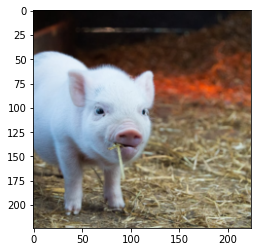

In [14]:
plt.figure()
imshow(image)

사전 학습된(pretrained) 모델을 불러와 사용

In [16]:
# 입력 데이터 정규화를 위한 클래스 정의
class Normalize(nn.Module):
  def __init__(self, mean, std):
    super(Normalize,self).__init__()
    self.register_buffer('mean', torch.Tensor(mean))
    self.register_buffer('std', torch.Tensor(std))

  def forward(self, input):
    mean = self.mean.reshape(1,3,1,1)
    std = self.std.reshape(1, 3, 1, 1)
    return (input - mean) / std


In [17]:
# 공격자가 가지고 있는 torch.Tensor 형식의 이미지 데이터는 입력 정규화를 거치기 전이므로, 정규화 이후에 모델에 넣도록 설정
model = nn.Sequential(
    # 기본적인 ResNet18과 동일한 동작을 위하여 정규화 레이어 추가
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
).to(device).eval() # 모델을 GPU로 옮기기 및 평가(테스트) 모드로 변경

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [18]:
# 기본적인 이미지를 실제 모델에 넣어 결과 확인
outputs = model(image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 341 / 클래스명: hog, pig, grunter, squealer, Sus scrofa / 확률: 98.5879%
인덱스: 342 / 클래스명: wild boar, boar, Sus scrofa / 확률: 0.5958%
인덱스: 104 / 클래스명: wallaby, brush kangaroo / 확률: 0.364%
인덱스: 338 / 클래스명: guinea pig, Cavia cobaya / 확률: 0.118%
인덱스: 106 / 클래스명: wombat / 확률: 0.0917%
